In [24]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import pims
from skimage.measure import regionprops


In [25]:
home_path = '/home/idies/workspace/codex/PD1_polarization/'
cell_data = pd.read_csv(home_path+'reg5_mouse89_outlines_and_expression.csv')

In [26]:
channelNames = list(pd.read_csv(home_path+'channelNames.txt',header = None)[0].values)

In [27]:
cell_data.head()

,CellID,tilename,Xroi,Yroi,Xtile,Ytile,ClusterID,CD62L,Siglec-H,CD86,...,X_withinTile,Y_withinTile,Z,size,cyc20_ch2blnk,cyc20_ch3blnk,cyc20_ch4blnk,cyc21_ch2blnk,cyc21_ch3blnk,cyc21_ch4blnk
0,0-1201-4,reg005_X01_Y02,2_2_2_2_2_2_2_2_2_2_2_1_1_1_1_1_1_1_1_1_1_1_0_...,478_479_480_481_482_483_484_485_486_487_488_47...,1,2,3262,477.369232,46.163620,123.079987,...,0,481,4,566,0.086064,0.000000,0.000000,0.511932,0.000000,0.000000
1,0-1216-4,reg005_X01_Y02,2_2_2_2_2_2_2_2_2_2_2_2_2_2_1_2_1_1_1_1_1_1_1_...,489_490_491_492_493_494_495_496_497_498_499_50...,1,2,3262,0.000000,0.000000,117.690712,...,0,496,4,585,0.000000,3.202495,4.067975,0.000000,12.229112,21.761768
2,0-123-4,reg005_X01_Y01,0_0_0_0_0_1_0_1_0_1_0_1_0_1_0_1_0_1_0_1_0_1_0_...,104_105_106_107_108_104_109_105_110_106_111_10...,1,1,3223,0.000000,0.000000,0.000000,...,0,123,4,4086,36.213600,5.332117,1.150246,90.962128,16.062859,4.204434
3,0-1268-3,reg005_X01_Y03,0_0_0_0_0_0_0_0_0_0_0_1_0_0_1_0_1_0_0_1_0_1_0_...,26_27_28_29_30_31_32_33_34_35_36_26_37_38_27_3...,1,3,3262,383.789124,62.661911,265.210876,...,0,44,3,2519,0.000000,2.596656,4.500194,0.000000,11.984420,16.527153
4,0-1285-3,reg005_X01_Y03,0_0_0_0_0_0_0_0_0_1_1_1_1_1_1_1_1_1_1_2_2_2_2_...,57_58_59_60_62_63_64_65_66_58_59_60_61_62_63_6...,1,3,3246,0.000000,0.000000,8.862731,...,0,61,3,385,1.368026,0.000000,0.000000,3.603063,0.000000,0.000000


In [28]:
def get_channel_index(chan,num_zs=7,z_indices = range(7)):
    cycle = chan//4
    channel = chan%4
    index = [cycle*4*num_zs+(z*4)+channel for z in z_indices]
    return index  

    
    
def read_cells(tile_name,cell_data):
    '''
    extract cells of given tile.  
    
    tile_name:  string of tile name (not including '.tif' e.g: reg005_X01_Y01)
    cell_data:  dataframe of cell regions, expression info and other meta data
    
    returns subset of cell_data corresponding to a tile and dict with keys as CellID and values as np array of region pixels 
    *note values are in x,y format (not rows, cols)
    '''
    tile_cells = cell_data[cell_data['tilename']==tile_name]
    roisX = np.core.defchararray.split(tile_cells['Xroi'].values.astype(str),sep = '_')
    roisY = np.core.defchararray.split(tile_cells['Yroi'].values.astype(str),sep = '_')
    roi = {i:np.array([x,y]).astype(int) for (i,x,y) in zip(tile_cells['CellID'].values,roisX,roisY) if (len(x)>1 and len(y)>1)} 
    return tile_cells,roi

def read_tile_image(tile_name,channelNames,markers,zs,tile_direc ):
    '''
    extract desired channels and zs from raw image
    
    tile_name:  string of tile name (not including '.tif' e.g: reg005_X01_Y01)
    channelNames:  list of proteins in order found in image (not including Zs)
    markers:    list of proteins to view  e.g: PD1,CD3 etc 
    zs:         list of z coordinates to extract
    tile_direc:  directory where tile data is saved
    
    *note raw image is flattened from following shape (num_cycles,num_zs,num_channels)
    
    returns: numpy array in following shape (num_markers,num_zs,nrows,ncols)
    '''
    indices = [get_channel_index(channelNames.index(marker),z_indices = zs) for marker in markers]
    indices = [k for i in indices for k in i]
    path = '{}/{}.tif'.format(tile_direc,tile_name)
    s = pims.TiffStack(path)
    img = np.array(s[indices]).reshape(len(markers),len(zs),*s.frame_shape)
    return img

 
def match_tile_and_cells(tile_name,cell_data,channelNames,markers,tile_direc = home_path+'mouse_number_89_reg005_tiles'):
    '''
    wrapper function to get imge and cells of a given tile with desired markers and zs 
    
    tile_name:  string of tile name (not including '.tif' e.g: reg005_X01_Y01)
    cell_data:  dataframe of cell regions, expression info and other meta data
    channelNames:  list of proteins in order found in image (not including Zs)
    markers:    list of proteins to view  e.g: PD1,CD3 etc
    tile_direc:  directory where tile data is saved
    
    returns: np.array(num_markers,num_zs,nrows,ncols),dataframe (subset of cell_data), dict cellid: cell pixels (x,y))
    
    '''
    img = read_tile_image(tile_name,channelNames,markers,zs,tile_direc)
    tile_cells,roi = read_cells(tile_name,cell_data)
    return img,tile_cells,roi
    
    
    
    

In [29]:
tile_name = 'reg005_X04_Y04'
markers = ['DNA_1','PD1','CD3']
zs = [0,4,7]

gated_positive = pd.read_csv(home_path+'PD1 positive cells of reg5 mouse 89 gated using TYRP1_PD1.txt')


#IMAGE,TILE_CELLS,ROI = match_tile_and_cells(tile_name,cell_data,channelNames,markers)
IMAGE,TILE_CELLS,ROI = match_tile_and_cells(tile_name,gated_positive,channelNames,markers)


In [30]:
gated_positive = pd.read_csv(home_path+'PD1 positive cells of reg5 mouse 89 gated using TYRP1_PD1.txt')
gated_tile = gated_positive[gated_positive['tilename']==tile_name]

In [31]:
gated_tile

,CellID,tilename,Xroi,Yroi,Xtile,Ytile,ClusterID,CD62L,Siglec-H,CD86,...,X_withinTile,Y_withinTile,Z,size,cyc20_ch2blnk,cyc20_ch3blnk,cyc20_ch4blnk,cyc21_ch2blnk,cyc21_ch3blnk,cyc21_ch4blnk
326,2023-1811-4,reg005_X04_Y04,0_1_1_2_2_2_2_3_3_3_3_3_3_4_4_4_4_4_4_4_6_6_6_...,84_83_84_82_83_84_85_81_82_83_84_85_86_80_81_8...,4,4,3247,4659.979492,679.557983,1687.439941,...,7,83,4,1114,32.064602,12.448558,13.390123,113.579567,54.075951,58.449020
328,2026-1796-4,reg005_X04_Y04,0_0_0_0_0_0_0_0_0_1_1_1_1_1_1_1_1_1_2_2_2_2_2_...,61_62_63_64_65_66_67_68_69_61_62_63_64_65_66_6...,4,4,3182,2923.699463,474.716217,0.000000,...,10,68,4,1464,22.251339,17.422150,14.396462,64.705772,61.222511,56.586933
330,2041-1801-4,reg005_X04_Y04,16_16_18_18_18_18_18_18_18_18_18_18_18_19_19_1...,75_76_69_70_71_72_73_74_75_76_77_78_79_67_68_6...,4,4,3247,832.555481,708.846069,3644.684570,...,25,73,4,2646,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
335,2053-1822-4,reg005_X04_Y04,28_28_28_28_28_28_28_29_28_29_28_29_29_28_29_2...,91_92_93_94_95_96_97_90_98_91_99_92_93_100_94_...,4,4,3236,0.000000,840.637573,0.000000,...,37,94,4,2195,0.000000,0.000000,0.000000,71.684990,0.000000,4.786061
339,2063-1813-4,reg005_X04_Y04,40_40_40_40_40_41_41_41_41_41_41_42_42_42_42_4...,79_80_81_82_83_79_80_81_82_83_84_79_80_81_82_8...,4,4,3247,552.256592,1250.015137,712.146790,...,47,85,4,577,0.000000,0.000000,26.295389,0.000000,0.000000,0.000000
342,2080-1825-4,reg005_X04_Y04,62_62_62_62_63_63_63_65_65_64_66_60_61_60_61_6...,97_98_99_100_97_98_99_96_97_98_96_97_97_98_98_...,4,4,3262,0.000000,1614.206665,1201.473022,...,64,97,4,134,0.000000,145.105698,41.330620,0.000000,277.459412,126.965271
482,2405-2135-4,reg005_X04_Y04,381_381_380_381_380_381_381_381_381_383_383_38...,408_409_410_410_411_411_412_413_414_405_406_40...,4,4,3261,0.000000,586.457520,1499.087769,...,389,407,4,871,2280.910645,411.765839,85.028816,5956.416016,1163.817017,158.623978
534,2496-2175-4,reg005_X04_Y04,475_475_474_475_475_474_475_474_475_474_474_47...,441_442_442_443_444_443_445_444_446_445_446_44...,4,4,3247,945.141174,1041.622925,790.365540,...,480,447,4,1641,2115.810059,469.009064,168.109467,5754.986816,1402.337158,553.720764
545,2508-2177-4,reg005_X04_Y04,487_488_488_487_488_488_487_488_487_488_488_48...,443_441_442_444_443_444_445_445_446_446_447_44...,4,4,3247,1101.474243,605.117554,640.889099,...,492,449,4,1593,1978.354370,114.003632,152.940643,5385.612305,341.661804,454.381226
573,2547-2069-4,reg005_X04_Y04,527_527_527_527_527_525_527_525_527_525_527_52...,336_337_338_339_340_338_341_339_342_340_343_34...,4,4,3236,0.000000,120.044075,255.496811,...,531,341,4,866,0.000000,0.000000,2.211906,0.000000,0.000000,0.000000


In [32]:
IMAGE.shape

(3, 3, 504, 672)

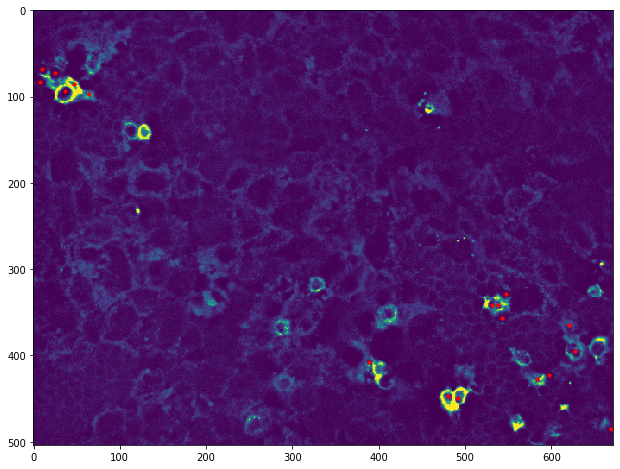

In [33]:
plt.figure(figsize = (12,8))
plt.imshow(IMAGE[2,1,:,:],vmax = 10000)
plt.scatter(gated_tile['X_withinTile'],gated_tile['Y_withinTile'],
           c = 'red',s = 10)

In [34]:
tile = IMAGE
cellid = '2041-1801-4'

coords = ROI[cellid]

(120, 50)

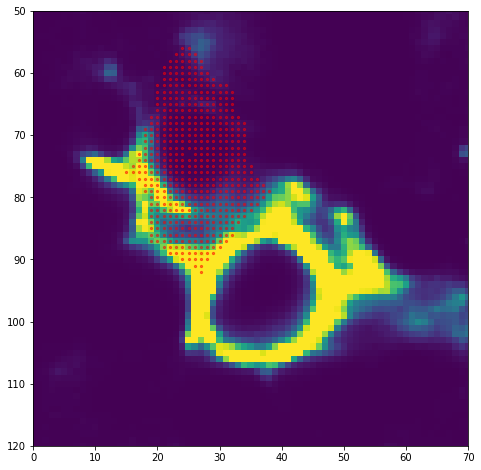

In [35]:
plt.figure(figsize = (8,8))
plt.imshow(tile[1,1,:,:],vmax = 60000)
plt.scatter(coords[0],coords[1],s = 5,c = 'red',alpha = .5)
plt.xlim(0,70)
plt.ylim(120,50)


In [36]:
pixels = tile[1,1,coords[1],coords[0]]

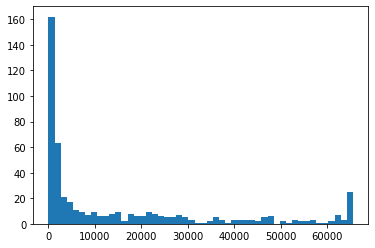

In [37]:
plt.hist(pixels,bins  =50);

## Cell Tensors


In [38]:
data_dir = 'codex/PD1_polarization/'
tile_names = [i.split('.tif')[0] for i in os.listdir(os.path.join(data_dir, 'mouse_number_89_reg005_tiles')) if 'tif' in i]
tile_names

['reg005_X01_Y02',
 'reg005_X05_Y02',
 'reg005_X05_Y05',
 'reg005_X01_Y05',
 'reg005_X06_Y07',
 'reg005_X02_Y07',
 'reg005_X06_Y09',
 'reg005_X02_Y09',
 'reg005_X07_Y08',
 'reg005_X03_Y08',
 'reg005_X07_Y06',
 'reg005_X03_Y06',
 'reg005_X03_Y01',
 'reg005_X07_Y01',
 'reg005_X04_Y03',
 'reg005_X04_Y04',
 'reg005_X06_Y08',
 'reg005_X02_Y08',
 'reg005_X02_Y01',
 'reg005_X06_Y01',
 'reg005_X06_Y06',
 'reg005_X02_Y06',
 'reg005_X05_Y04',
 'reg005_X01_Y04',
 'reg005_X01_Y03',
 'reg005_X05_Y03',
 'reg005_X04_Y05',
 'reg005_X04_Y02',
 'reg005_X07_Y07',
 'reg005_X03_Y07',
 'reg005_X07_Y09',
 'reg005_X03_Y09',
 'reg005_X04_Y01',
 'reg005_X04_Y06',
 'reg005_X04_Y08',
 'reg005_X07_Y04',
 'reg005_X03_Y04',
 'reg005_X03_Y03',
 'reg005_X07_Y03',
 'reg005_X06_Y05',
 'reg005_X02_Y05',
 'reg005_X02_Y02',
 'reg005_X06_Y02',
 'reg005_X05_Y09',
 'reg005_X01_Y09',
 'reg005_X05_Y07',
 'reg005_X01_Y07',
 'reg005_X03_Y02',
 'reg005_X07_Y02',
 'reg005_X07_Y05',
 'reg005_X03_Y05',
 'reg005_X04_Y09',
 'reg005_X04

In [41]:
data_dir = 'codex/PD1_polarization/'
save_dir = 'Storage/bmyury/shared_scripts_and_files/tensor_data'

os.makedirs(save_dir, exist_ok=True)
channelNames = list(pd.read_csv(os.path.join(data_dir, 'channelNames.txt'),header = None)[0].values)
cell_data = pd.read_csv(os.path.join(data_dir,'reg5_mouse89_outlines_and_expression.csv'))

gated_positive = pd.read_csv(home_path+'PD1 positive cells of reg5 mouse 89 gated using TYRP1_PD1.txt')
gated_tile = gated_positive[gated_positive['tilename']==tile_name]

def rois_to_binary_mask(Xroi, Yroi, whole_dim):
    binmask = np.zeros(whole_dim).astype(np.uint8)
    Xr = Xroi.split('_')
    Yr = Yroi.split('_')
    for i in range(len(Xr)):
        binmask[int(Yr[i]), int(Xr[i])] = 1
    return binmask


#tile_name = 'reg005_X04_Y04'
markers = ['DNA_1','PD1','CD3']
mask_cells = False # true to remove background, just one centered cell
zs = [0,1,2,3,4,5,6,7,8,9,10]
boxsize = 32

all_cells = []
all_cells_data = pd.DataFrame()
for idx, tile_name in enumerate(tile_names):
    tile_cells = []
    tile_cells_data = pd.DataFrame()
    print('processing', tile_name, idx, '/',len(tile_names))
    #IMAGE,TILE_CELLS,ROI = match_tile_and_cells(tile_name, cell_data,channelNames, markers)
    IMAGE,TILE_CELLS,ROI = match_tile_and_cells(tile_name, gated_positive, channelNames, markers)
    for index, row in TILE_CELLS.iterrows():
        binmask = rois_to_binary_mask(row['Xroi'], row['Yroi'], IMAGE.shape[2:]) 
        xc, yc = regionprops(binmask)[0].centroid
        if mask_cells:
            masked = binmask * IMAGE
        else:
            masked = IMAGE
        cell = masked[1, row['Z'], 
                     (int(xc)-boxsize//2):(int(xc)+boxsize//2), 
                     (int(yc)-boxsize//2):(int(yc)+boxsize//2)]
        if cell.shape == (boxsize, boxsize):
            all_cells.append(cell)
            all_cells_data=all_cells_data.append(row)
            tile_cells.append(cell)
            tile_cells_data=all_cells_data.append(row)
            
    print('tile cell count:', len(tile_cells), 'total cell count:', len(all_cells))
    if len(tile_cells) != 0:
        tile_cell_tensor = np.stack(tile_cells)
        np.save(os.path.join(save_dir, tile_name+'_background_tensor.npy'), tile_cell_tensor)
        tile_cells_data.to_csv(os.path.join(save_dir, tile_name+'_background_tensor_data.csv'), sep=',', index=False)



processing reg005_X01_Y02 0 / 63
tile cell count: 10 total cell count: 10
processing reg005_X05_Y02 1 / 63
tile cell count: 84 total cell count: 94
processing reg005_X05_Y05 2 / 63
tile cell count: 28 total cell count: 122
processing reg005_X01_Y05 3 / 63
tile cell count: 0 total cell count: 122
processing reg005_X06_Y07 4 / 63
tile cell count: 91 total cell count: 213
processing reg005_X02_Y07 5 / 63
tile cell count: 24 total cell count: 237
processing reg005_X06_Y09 6 / 63
tile cell count: 36 total cell count: 273
processing reg005_X02_Y09 7 / 63
tile cell count: 7 total cell count: 280
processing reg005_X07_Y08 8 / 63
tile cell count: 37 total cell count: 317
processing reg005_X03_Y08 9 / 63
tile cell count: 51 total cell count: 368
processing reg005_X07_Y06 10 / 63
tile cell count: 55 total cell count: 423
processing reg005_X03_Y06 11 / 63
tile cell count: 6 total cell count: 429
processing reg005_X03_Y01 12 / 63
tile cell count: 18 total cell count: 447
processing reg005_X07_Y01 1

In [42]:

cell_tensor = np.stack(all_cells)
np.save(os.path.join(save_dir, 'all_cells_background_tensor.npy'), cell_tensor)
all_cells_data.to_csv(os.path.join(save_dir, 'all_cells_background_tensor_data.csv'), sep=',', index=False)
